# Emotion Recognition Model
#### Gavin Jones, Cody Mott

###### Description

##### Import libraries 

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


2023-12-06 13:59:27.382566: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 13:59:27.426121: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Import data

In [2]:
# import data

face_data_df = pd.read_csv("data/icml_face_data.csv")
face_data_df.head()

print(face_data_df.columns)

Index(['emotion', ' Usage', ' pixels'], dtype='object')


# Preprocess Data

In [4]:
# drop unnesccary columns

face_data_df.drop(' Usage', axis=1, inplace= True)
print(face_data_df.columns)

Index(['emotion', ' pixels'], dtype='object')


In [5]:
# convert string format images into array format

face_data_df[' pixels'] = face_data_df[' pixels'].apply(
    lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

In [6]:
# split into images and labels
images = face_data_df[' pixels'].to_numpy()
labels = face_data_df['emotion'].to_numpy()

# normalize images
images = np.stack(images, axis=0)/255

# one hot encode labels
labels = tf.keras.utils.to_categorical(labels, num_classes=7)

# split data into train/validation/testing 70%/20%/10%

# 70% training, 30% temp
image_train, image_temp, label_train, label_temp = train_test_split(images, labels, test_size=0.3)  

# 67% training, 33% temp
image_val, image_test, label_val, label_test = train_test_split(image_temp, label_temp, test_size=0.33)  


 emotion dictionary
emotions = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"}

In [7]:

def count_data(labels):
    # Assuming label_train is a one-hot encoded array
    # Convert it back to integer labels
    

    # Count the number of samples for each category
    unique_labels_train, counts_train = np.unique(np.argmax(labels, axis=1), return_counts=True)

    #
    label_count_list = []

    # Display the count for each category
    for label, count in zip(unique_labels_train, counts_train):
        #print(f"Category {label}: {count} samples in data")
        label_count_list.append(count)

    return label_count_list

In [8]:
count_data(labels)

[4953, 547, 5121, 8989, 6077, 4002, 6198]

In [9]:
print(images.shape)

(35887, 48, 48, 1)


7420


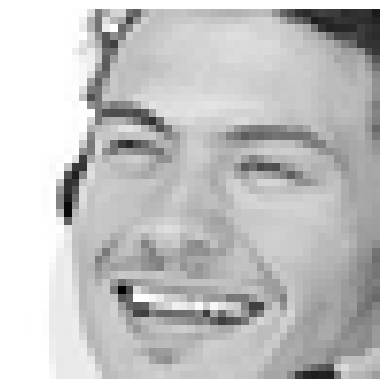

In [10]:
index = random.randint(0,image_train.shape[0]-1)
print(index)
plt.imshow(image_train[index], cmap='gray')
plt.axis('off') 
plt.show()

# Base Model

##### Build and compile

In [11]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the data for dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


2023-12-06 13:59:58.498807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 256)               1

##### Training

In [13]:
hist = model.fit(image_train, label_train, epochs=20, 
                    validation_data=(image_val, label_val), batch_size=32)

Epoch 1/20


2023-12-06 13:59:59.705096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-12-06 13:59:59.950533: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb5c4991a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 13:59:59.950571: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-06 13:59:59.954773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 14:00:00.081461: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


785/785 [==============================] - 6s 6ms/step - loss: 1.5956 - accuracy: 0.3699 - val_loss: 1.4533 - val_accuracy: 0.4556
Epoch 2/20
785/785 [==============================] - 4s 5ms/step - loss: 1.3785 - accuracy: 0.4709 - val_loss: 1.3816 - val_accuracy: 0.4805
Epoch 3/20
785/785 [==============================] - 4s 5ms/step - loss: 1.2561 - accuracy: 0.5182 - val_loss: 1.3350 - val_accuracy: 0.4990
Epoch 4/20
785/785 [==============================] - 4s 5ms/step - loss: 1.1411 - accuracy: 0.5695 - val_loss: 1.2946 - val_accuracy: 0.5120
Epoch 5/20
785/785 [==============================] - 4s 5ms/step - loss: 1.0150 - accuracy: 0.6182 - val_loss: 1.3816 - val_accuracy: 0.5048
Epoch 6/20
785/785 [==============================] - 4s 5ms/step - loss: 0.8739 - accuracy: 0.6791 - val_loss: 1.4053 - val_accuracy: 0.5241
Epoch 7/20
785/785 [==============================] - 4s 5ms/step - loss: 0.7186 - accuracy: 0.7409 - val_loss: 1.4888 - val_accuracy: 0.5213
Epoch 8/20
785/78

##### Training Evaluation

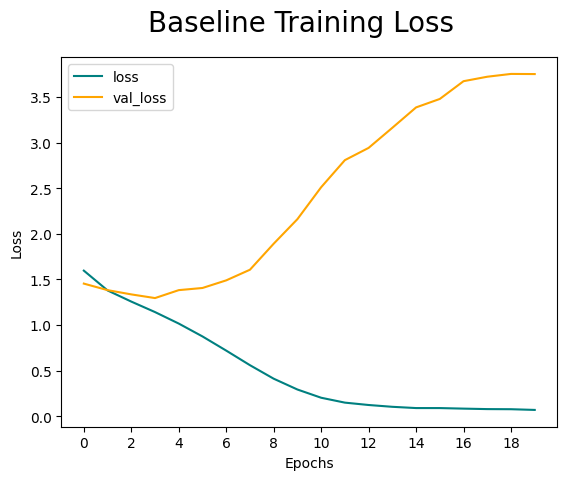

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Baseline Training Loss', fontsize=20)
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,20,2))
plt.show()

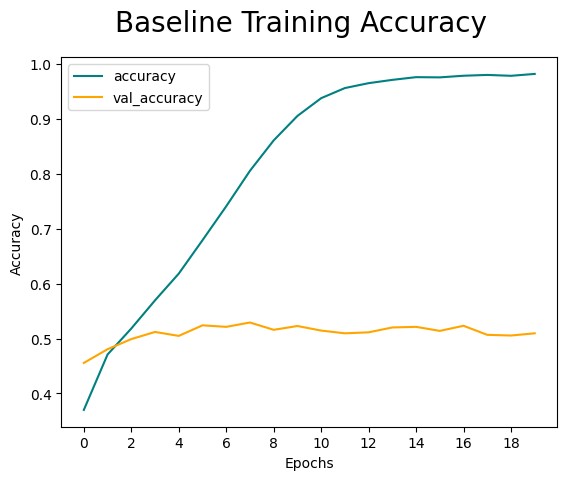

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Baseline Training Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,20,2))
plt.show()

##### Testing

In [16]:
predictions = model.predict(image_test)
predicted_classes = tf.argmax(predictions, axis=1)

accuracy = accuracy_score(tf.argmax(label_test, axis=1).numpy(), predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



112/112 [==============================] - 0s 2ms/step
Test Accuracy: 51.94%


# Data Augmentation

In [17]:
# func difference in labels
# param: list of label counts
# find max
# for each label count return a list that contains max-count

def diff_in_labels(counts):

    max_count =max(counts)

    diff_in_labels_list = []

    for count in counts:
        diff_in_labels_list.append(max_count-count)

    return diff_in_labels_list

In [18]:
# Creating the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,    # Small rotations, as large rotations might distort facial features
    width_shift_range=0.05,  # Slight horizontal shifts to simulate head movements
    height_shift_range=0.05,  # Slight vertical shifts
    shear_range=0.1,     # Small shearing; too much might change the expression
    zoom_range=0.05,      # Slight zooming in and out
    horizontal_flip=True,  # Flipping might be useful to generalize learning
    vertical_flip=False,   # Flipping vertically is less likely to represent real-world scenarios
    fill_mode='nearest',   # 'nearest' is typically preferred for facial data
)

In [19]:
def augment_images(images, labels):
    class_counts = np.sum(labels, axis=0)

    # Find the maximum class count
    max_class_count = np.max(class_counts)

    augmented_images = []
    augmented_labels = []

    # Iterate over each class
    for class_index in range(len(class_counts)):
        # Calculate how many images need to be generated for this class
        num_to_generate = int(max_class_count - class_counts[class_index])

        # Only generate if additional images are needed
        if num_to_generate > 0:
            # Filter images of the current class
            class_images = images[np.argmax(labels, axis=1) == class_index]
            class_labels = labels[np.argmax(labels, axis=1) == class_index]

            # Create a data generator for the current class
            data_generator = datagen.flow(class_images, class_labels, batch_size=1)

            # Generate required number of images
            for num in range(num_to_generate):
                img, num = next(data_generator)
                augmented_images.append(img[0])
                # Create a label for the augmented image
                label = np.zeros(len(class_counts))
                label[class_index] = 1
                augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

In [20]:
augmented_images_train, augmented_labels_train = augment_images(image_train, label_train)

14678


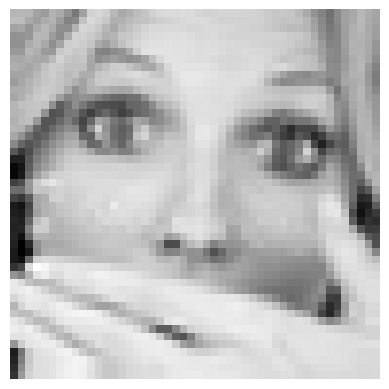

In [21]:
index = random.randint(0,augmented_images_train.shape[0]-1)
print(index)
plt.imshow(augmented_images_train[index], cmap='gray')
plt.axis('off') 
plt.show()

In [22]:
# Combining the augmented data with original data
images_train_augmented = np.concatenate([image_train, augmented_images_train])
labels_train_augmented = np.concatenate([label_train, augmented_labels_train])


6206


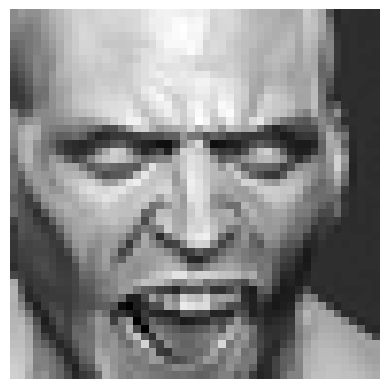

In [23]:
index = random.randint(0,images_train_augmented.shape[0]-1)
print(index)
plt.imshow(images_train_augmented[index], cmap='gray')
plt.axis('off') 
plt.show()

# Improved Model

In [24]:
aug_model = Sequential()

# Convolutional layer 1
aug_model.add(Conv2D(16, kernel_size=(3, 3), activation='leaky_relu', input_shape=(48, 48, 1)))
aug_model.add(MaxPooling2D())
aug_model.add(Dropout(0.25))

# Convolutional layer 2
aug_model.add(Conv2D(32, kernel_size=(3, 3), activation='leaky_relu'))
aug_model.add(MaxPooling2D())
aug_model.add(Dropout(0.25))

# Convolutional layer 3
aug_model.add(Conv2D(64, kernel_size=(3, 3), activation='leaky_relu'))
aug_model.add(MaxPooling2D())
aug_model.add(Dropout(0.25))

# Convolutional layer 3
aug_model.add(Conv2D(128, kernel_size=(3, 3), activation='leaky_relu'))
aug_model.add(MaxPooling2D())
aug_model.add(Dropout(0.25))

# Flatten the data for dense layers
aug_model.add(Flatten())

# Dense layers
aug_model.add(Dense(128, activation='leaky_relu'))
aug_model.add(Dropout(0.25))
aug_model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
aug_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 23, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)       

In [26]:
aug_hist = aug_model.fit(images_train_augmented, labels_train_augmented, epochs=100, 
                    validation_data=(image_val, label_val), batch_size=64)

Epoch 1/100


2023-12-06 14:07:19.144512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


687/687 [==============================] - 8s 9ms/step - loss: 1.8161 - accuracy: 0.2614 - val_loss: 1.5326 - val_accuracy: 0.4133
Epoch 2/100
687/687 [==============================] - 6s 8ms/step - loss: 1.5381 - accuracy: 0.4127 - val_loss: 1.4517 - val_accuracy: 0.4467
Epoch 3/100
687/687 [==============================] - 6s 8ms/step - loss: 1.4224 - accuracy: 0.4624 - val_loss: 1.2972 - val_accuracy: 0.5088
Epoch 4/100
687/687 [==============================] - 6s 8ms/step - loss: 1.3598 - accuracy: 0.4868 - val_loss: 1.3011 - val_accuracy: 0.5066
Epoch 5/100
687/687 [==============================] - 6s 8ms/step - loss: 1.3101 - accuracy: 0.5052 - val_loss: 1.2481 - val_accuracy: 0.5310
Epoch 6/100
687/687 [==============================] - 6s 8ms/step - loss: 1.2810 - accuracy: 0.5155 - val_loss: 1.2356 - val_accuracy: 0.5346
Epoch 7/100
687/687 [==============================] - 6s 8ms/step - loss: 1.2546 - accuracy: 0.5250 - val_loss: 1.2049 - val_accuracy: 0.5476
Epoch 8/100

687/687 [==============================] - 6s 8ms/step - loss: 1.0071 - accuracy: 0.6216 - val_loss: 1.0848 - val_accuracy: 0.5977
Epoch 59/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0106 - accuracy: 0.6197 - val_loss: 1.0766 - val_accuracy: 0.5977
Epoch 60/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0144 - accuracy: 0.6183 - val_loss: 1.0793 - val_accuracy: 0.6010
Epoch 61/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0054 - accuracy: 0.6222 - val_loss: 1.0915 - val_accuracy: 0.5982
Epoch 62/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0077 - accuracy: 0.6191 - val_loss: 1.0954 - val_accuracy: 0.5935
Epoch 63/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0062 - accuracy: 0.6212 - val_loss: 1.0689 - val_accuracy: 0.6013
Epoch 64/100
687/687 [==============================] - 6s 8ms/step - loss: 1.0040 - accuracy: 0.6200 - val_loss: 1.0898 - val_accuracy: 0.5999
Epoch

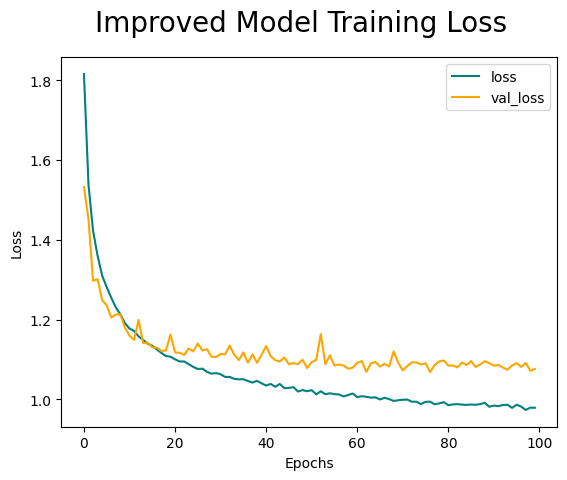

In [32]:
fig = plt.figure()
plt.plot(aug_hist.history['loss'], color='teal', label='loss')
plt.plot(aug_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Improved Model Training Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

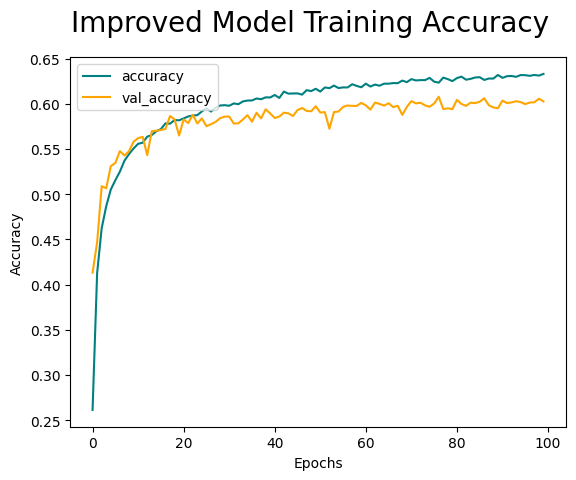

In [31]:
fig = plt.figure()
plt.plot(aug_hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(aug_hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Improved Model Training Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [33]:
predictions = aug_model.predict(image_test)
predicted_classes = tf.argmax(predictions, axis=1)

accuracy = accuracy_score(tf.argmax(label_test, axis=1).numpy(), predicted_classes)

test_loss, test_acc = aug_model.evaluate(image_test, label_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


112/112 [==============================] - 0s 3ms/step - loss: 1.0609 - accuracy: 0.6027
Test Accuracy: 60.27%


In [34]:
y_true = np.argmax(label_test, axis=1)
y_pred = np.argmax(predictions, axis=1)



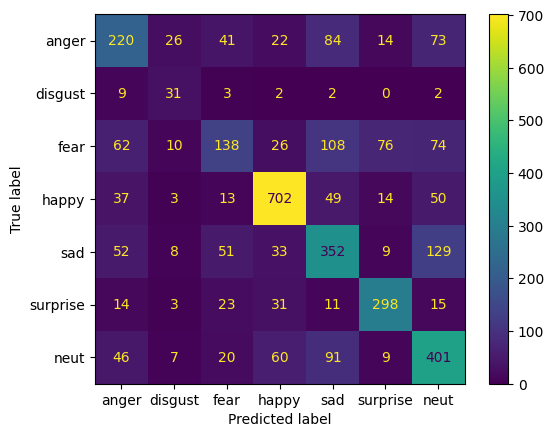

In [37]:

cm = confusion_matrix(y_true, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['anger','disgust','fear','happy','sad','surprise','neut'])
cmp.plot()
plt.show()

# Remove Data

In [38]:
# Drop 'Category 1'
df = face_data_df[face_data_df['emotion'] != 1]
df = df[df['emotion'] != 6]

In [39]:
# Find the count of the smallest category, excluding 'Category 3'
min_category_count = df[df['emotion'] != 3]['emotion'].value_counts().min()

# Downsample 'Category 3'
df_category3_downsampled = df[df['emotion'] == 3].sample(min_category_count, random_state=0)
df_other_categories = df[df['emotion'] != 3]

# Combine the downsampled category with the rest
face_data_df_downsampled = pd.concat([df_category3_downsampled, df_other_categories])

# Shuffle the dataset
face_data_df_downsampled = face_data_df_downsampled.sample(frac=1, random_state=0).reset_index(drop=True)

In [40]:
# split into images and labels
images = face_data_df_downsampled[' pixels'].to_numpy()
labels = face_data_df_downsampled['emotion'].to_numpy()

# normalize images
images = np.stack(images, axis=0)

# renumber labels
labels = np.where(labels > 0, labels - 1, labels)

# one hot encode labels
labels = tf.keras.utils.to_categorical(labels, num_classes=5)

# split data into train/validation/testing 70%/20%/10%

# 70% training, 30% temp
image_train, image_temp, label_train, label_temp = train_test_split(images, labels, test_size=0.3)  

# 67% training, 33% temp
image_val, image_test, label_val, label_test = train_test_split(image_temp, label_temp, test_size=0.33)

# Emotion Recognition Model

In [41]:
'''
These callback methods were taken from 
https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition
'''


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [42]:
eRec_model = Sequential()

# Convolutional layer 1
eRec_model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(48, 48, 1), kernel_initializer= 'glorot_normal'))
eRec_model.add(BatchNormalization())
eRec_model.add(Activation(activation='leaky_relu'))
eRec_model.add(MaxPooling2D())
eRec_model.add(Dropout(0.25))

# Convolutional layer 2
eRec_model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer= 'glorot_normal'))
eRec_model.add(BatchNormalization())
eRec_model.add(Activation(activation='leaky_relu'))
eRec_model.add(MaxPooling2D())
eRec_model.add(Dropout(0.25))

# Convolutional layer 3
eRec_model.add(Conv2D(64, kernel_size=(3, 3), kernel_initializer= 'glorot_normal'))
eRec_model.add(BatchNormalization())
eRec_model.add(Activation(activation='leaky_relu'))
eRec_model.add(MaxPooling2D())
eRec_model.add(Dropout(0.25))

# Convolutional layer 4
eRec_model.add(Conv2D(128, kernel_size=(3, 3), kernel_initializer= 'glorot_normal'))
eRec_model.add(BatchNormalization())
eRec_model.add(Activation(activation='leaky_relu'))
eRec_model.add(MaxPooling2D())
eRec_model.add(Dropout(0.25))

# Flatten the data for dense layers
eRec_model.add(Flatten())

# Dense layers
eRec_model.add(Dense(128, activation='leaky_relu') )
eRec_model.add(Dropout(0.25))
eRec_model.add(Dense(5, activation='softmax'))  # 5 output classes for emotions

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
eRec_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
eRec_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 23, 23, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 32)       

In [44]:
eRec_hist = eRec_model.fit(image_train, label_train, epochs=100, 
                    validation_data=(image_val, label_val), batch_size=128, callbacks=callbacks )

Epoch 1/100


2023-12-06 14:18:03.897091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 5s 17ms/step - loss: 1.6564 - accuracy: 0.2731 - val_loss: 1.5460 - val_accuracy: 0.2925 - lr: 0.0010
Epoch 2/100
133/133 [==============================] - 2s 13ms/step - loss: 1.4900 - accuracy: 0.3407 - val_loss: 1.3972 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 3/100
133/133 [==============================] - 2s 13ms/step - loss: 1.4178 - accuracy: 0.3781 - val_loss: 1.3300 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 4/100
133/133 [==============================] - 2s 13ms/step - loss: 1.3676 - accuracy: 0.4063 - val_loss: 1.3148 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 5/100
133/133 [==============================] - 2s 13ms/step - loss: 1.3354 - accuracy: 0.4278 - val_loss: 1.2585 - val_accuracy: 0.4624 - lr: 0.0010
Epoch 6/100
133/133 [==============================] - 2s 13ms/step - loss: 1.3057 - accuracy: 0.4429 - val_loss: 1.2261 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 7/100
133/133 [==============================] - 2s 13ms/step - 

Epoch 52/100
133/133 [==============================] - 2s 13ms/step - loss: 0.8296 - accuracy: 0.6654 - val_loss: 0.9401 - val_accuracy: 0.6264 - lr: 5.0000e-04
Epoch 53/100
133/133 [==============================] - 2s 13ms/step - loss: 0.8302 - accuracy: 0.6646 - val_loss: 0.9351 - val_accuracy: 0.6327 - lr: 5.0000e-04
Epoch 54/100
131/133 [============================>.] - ETA: 0s - loss: 0.8240 - accuracy: 0.6675
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
133/133 [==============================] - 2s 13ms/step - loss: 0.8235 - accuracy: 0.6673 - val_loss: 0.9287 - val_accuracy: 0.6307 - lr: 5.0000e-04
Epoch 55/100
133/133 [==============================] - 2s 13ms/step - loss: 0.8121 - accuracy: 0.6738 - val_loss: 0.9375 - val_accuracy: 0.6334 - lr: 2.5000e-04
Epoch 56/100
133/133 [==============================] - 2s 13ms/step - loss: 0.8154 - accuracy: 0.6699 - val_loss: 0.9393 - val_accuracy: 0.6272 - lr: 2.5000e-04
Epoch 57/100
133/133 [======

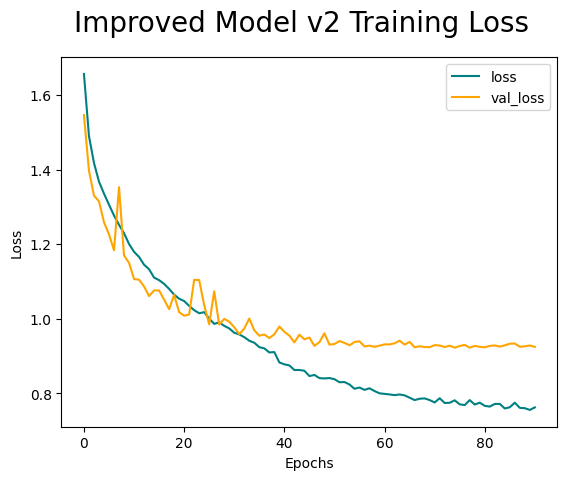

In [45]:
fig = plt.figure()
plt.plot(eRec_hist.history['loss'], color='teal', label='loss')
plt.plot(eRec_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Improved Model v2 Training Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

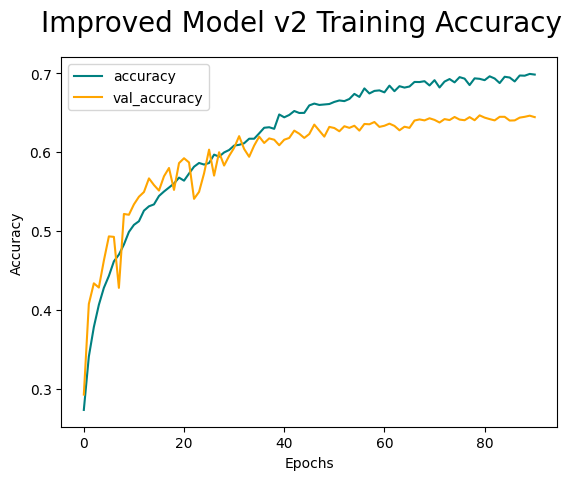

In [46]:
fig = plt.figure()
plt.plot(eRec_hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(eRec_hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Improved Model v2 Training Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [47]:
predictions = eRec_model.predict(image_test)
predicted_classes = tf.argmax(predictions, axis=1)

test_loss, test_acc = eRec_model.evaluate(image_test, label_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


75/75 [==============================] - 0s 3ms/step - loss: 0.9030 - accuracy: 0.6451
Test Accuracy: 64.51%


In [48]:
y_true = np.argmax(label_test, axis=1)
y_pred = np.argmax(predictions, axis=1)

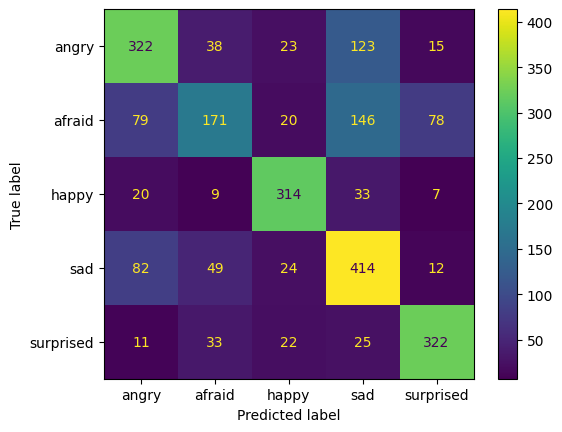

In [49]:
cm = confusion_matrix(y_true, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry',"afraid","happy","sad","surprised"])
cmp.plot()
plt.show()

# Save Model

In [ ]:
from tensorflow.keras.models import load_model

model.save("model.h5")
aug_model.save("aug_model.h5")
eRec_model.save("eRec_model.h5")